In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import scipy as sc
import pandas as pd

In [2]:
price_data = pd.read_csv("../../price_filled2.csv", sep = ";")

tab_price = price_data.to_numpy()[:,3:]
dates_tab = price_data.columns[2:].to_numpy(dtype = np.str)
tab_price.shape


(756, 1824)

In [3]:
current_month = dates_tab[0][:-3]
# print(current_month)
month_first_index = {current_month : 0}

for i in range(len(dates_tab)) :
    if (dates_tab[i][-4] != current_month[-1]) :
        current_month = dates_tab[i][:-3]
        month_first_index[current_month] = i
#     print(dates_tab[i][-4], current_month[-1])

print(month_first_index)

{'2014-01': 0, '2014-02': 22, '2014-03': 42, '2014-04': 63, '2014-05': 84, '2014-06': 103, '2014-07': 123, '2014-08': 145, '2014-09': 165, '2014-10': 187, '2014-11': 210, '2014-12': 229, '2015-01': 251, '2015-02': 272, '2015-03': 292, '2015-04': 314, '2015-05': 335, '2015-06': 352, '2015-07': 374, '2015-08': 396, '2015-09': 417, '2015-10': 439, '2015-11': 461, '2015-12': 481, '2016-01': 503, '2016-02': 523, '2016-03': 544, '2016-04': 566, '2016-05': 587, '2016-06': 607, '2016-07': 629, '2016-08': 649, '2016-09': 671, '2016-10': 693, '2016-11': 714, '2016-12': 734, '2017-01': 756, '2017-02': 778, '2017-03': 798, '2017-04': 821, '2017-05': 840, '2017-06': 860, '2017-07': 881, '2017-08': 901, '2017-09': 921, '2017-10': 942, '2017-11': 964, '2017-12': 985, '2018-01': 1005, '2018-02': 1027, '2018-03': 1047, '2018-04': 1069, '2018-05': 1089, '2018-06': 1108, '2018-07': 1129, '2018-08': 1151, '2018-09': 1173, '2018-10': 1193, '2018-11': 1216, '2018-12': 1237, '2019-01': 1257, '2019-02': 1279,

In [4]:
indexes = np.array(list(month_first_index.values()))
total = []
for i in range(len(month_first_index)-1) :
    X = tab_price[:,indexes[i]:indexes[i+1]].mean(axis = 1)
    total.append(X)
total.append(tab_price[:,indexes[-1]:].mean(axis = 1))
result = np.column_stack(total)
n_data = result.shape[1]

In [5]:
IPC_df = pd.read_csv("../../valeurs_mensuelles.csv", sep = ";")
dates = IPC_df["Libellé"].to_numpy()[3:]
dates = dates[::-1].copy()

IPC = IPC_df[IPC_df.columns[1]].iloc[3:].to_numpy(dtype = np.float)[::-1]

IPC_selec = IPC[-n_data:]
IPC_selec.shape

(89,)

In [6]:
X = result.copy()
X0 = np.transpose(X) #juste les données de base
X1 = np.transpose(np.vstack((X[:,1:], IPC_selec[:-1]))) #on donne en plus le point t-1
X2 = np.transpose(np.vstack((np.transpose(X1)[:,1:], IPC_selec[:-2]))) #on donne en plus le point t-2

Y0 = IPC_selec
Y1 = IPC_selec[1:]
Y2 = IPC_selec[2:]



In [24]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X1, Y1, test_size = .2)
# Xtrain = Xtrain.T
# Xtest = Xtest.T

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

In [26]:
alpha = 0.9
params = {'n_estimators': 350,
          'max_depth': 6,
          'alpha' : alpha,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'ls'}

In [27]:
reg_up = GradientBoostingRegressor(**params)

reg_up = reg_up.fit(Xtrain, Ytrain)

y_upper_test = reg_up.predict(Xtest)
y_upper_train = reg_up.predict(Xtrain)

In [28]:
reg_low = GradientBoostingRegressor(**params)
reg_low.set_params(alpha=1.0 - alpha)
reg_low = reg_low.fit(Xtrain, Ytrain)

y_lower_test = reg_low.predict(Xtest)
y_lower_train = reg_low.predict(Xtrain)

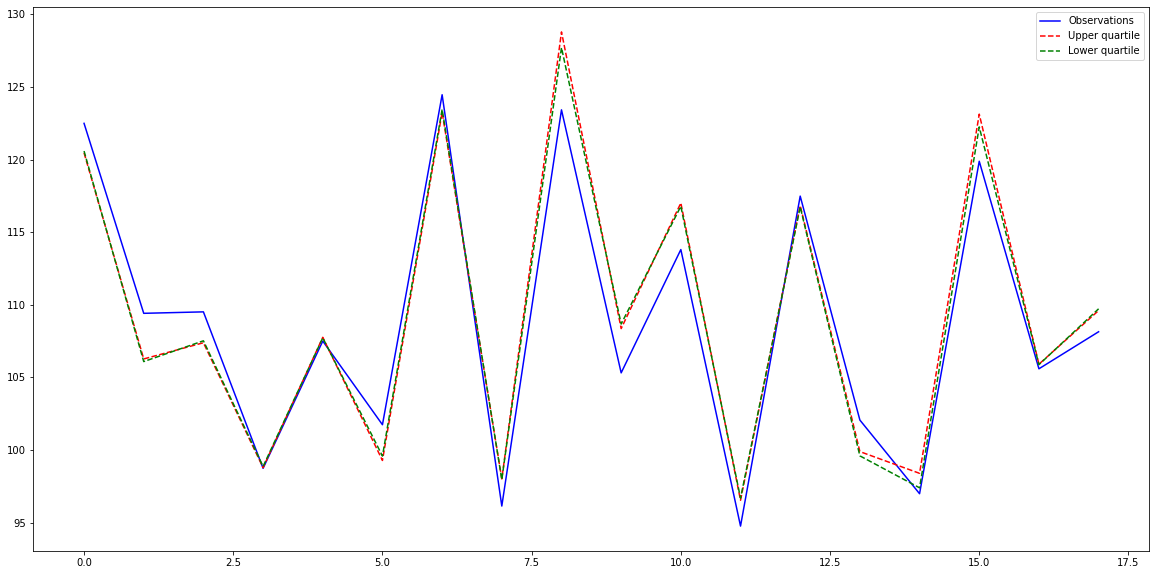

In [29]:
fig = plt.figure(figsize = (20,10))

line3 = plt.plot(Ytest,'b',label=u'Observations')

line1 = plt.plot(y_upper_test, 'r--', label='Upper quartile')
line2 = plt.plot(y_lower_test, 'g--',label='Lower quartile')


# plt.fill_between(range(0,len(y_upper_train)),y_upper_train, y_lower_train, alpha =0.1)

plt.legend()
# plt.xlim(50,60)

plt.show()

In [13]:
def dist(upper_bound, lower_bound, obs) :
    if obs<= upper_bound and obs <= lower_bound :
        return lower_bound-obs
    elif obs>= upper_bound and obs >= lower_bound :
        return obs - upper_bound
    else :
        return 0

In [14]:
def cout(upper, lower, obs) :
    S = 0
    for i in range(len(obs)) :
        S += dist(upper[i], lower[i], obs[i])
    return S/len(obs)

In [15]:
cout(y_upper_test, y_lower_test, Ytest)

2.3554257517887365

In [16]:
X2[-1].shape


(758,)

In [17]:
reg_up = GradientBoostingRegressor(**params)

reg_up = reg_up.fit(X2[:-1], Y2[:-1])

data = X2[-1].copy()

y_upper = reg_up.predict(data.reshape(1, -1))


reg_low = GradientBoostingRegressor(**params)
reg_low.set_params(alpha=1.0 - alpha)
reg_low = reg_low.fit(X2[:-1], Y2[:-1])

y_lower = reg_low.predict(data.reshape(1, -1))


In [18]:
print(y_lower, y_upper)

[128.02777748] [128.35509516]


In [19]:
print(Y)

NameError: name 'Y' is not defined